In [1]:
import numpy as np
import pylab as plt
from scipy import stats, signal
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error
from os import listdir
import scipy
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow import keras
from tensorflow.keras import layers
from LLR import LLR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
plt.rcParams['figure.figsize'] = [25, 10]

/global/homes/a/ashodkh/.conda/envs/myenv/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [27]:
perlmutter = False
cori = True

## reading fluxes and equivalent widths
lines = ["OII_DOUBLET_EW","HGAMMA_EW","HBETA_EW","OIII_4959_EW","OIII_5007_EW","NII_6548_EW"\
         ,"HALPHA_EW","NII_6584_EW","SII_6716_EW","SII_6731_EW"]
l = 6

run = 0
m = 0
loga = True

raw = False
raw_unmasked = True
fastspec = False
fastphot = False


Ns = [16]
decades = 1 ## number of 10k galaxy files I want to load and combine
for N in Ns:
    n = 10*10**3
    fluxes_bin = np.zeros([decades*n, N-1]) ## fluxes are separated into groups of 10k galaxies
    print(fluxes_bin.shape)
    if perlmutter:
        if raw:
            for i in range(decades):
                fluxes_bin[n*i:n*(i+1),:] = np.load("/pscratch/sd/a/ashodkh/fluxes_from_spectra/raw/fluxes"\
                                                    +str(i)+ "_selection"+str(run)+"_"+str(lines[l])+"_bins"+str(N)+".txt.npz")["arr_0"]
        if fastspec:
            for i in range(decades):
                fluxes_bin[n*i:n*(i+1),:] = np.load("/pscratch/sd/a/ashodkh/fluxes_from_spectra/fastspec/fluxes_fastspec"\
                                                    +str(i)+ "_selection"+str(run)+"_"+str(lines[l])+"_bins"+str(N)+".txt.npz")["arr_0"]
        if fastphot:
            for i in range(decades):
                fluxes_bin[n*i:n*(i+1),:] = np.load("/pscratch/sd/a/ashodkh/fluxes_from_spectra/fastphot/fluxes_fastphot"\
                                                    +str(i)+ "_selection"+str(run)+"_"+str(lines[l])+"_bins"+str(N)+".txt.npz")["arr_0"]
        zs = np.load("/pscratch/sd/a/ashodkh/target_selection/zs_selection" + str(run) + "_" + str(lines[l]) + ".txt.npz")["arr_0"]
        target_lines = np.load("/pscratch/sd/a/ashodkh/target_selection/line_ews_selection" + str(run) + "_" + str(lines[l]) + ".txt.npz")["arr_0"]
        line_ivars = np.load("/pscratch/sd/a/ashodkh/target_selection/line_ivars_selection" + str(run) + "_" + str(lines[l]) + ".txt.npz")["arr_0"]
    
    if cori:
        if raw:
            for i in range(decades):
                fluxes_bin[n*i:n*(i+1),:] = np.load("/global/cscratch1/sd/ashodkh/fluxes_from_spectra/raw_masked/fluxes"\
                                                    +str(i)+ "_selection"+str(run)+"_"+str(lines[l])+"_bins"+str(N)+".txt.npz")["arr_0"]
        if raw_unmasked:
            for i in range(decades):
                fluxes_bin[n*i:n*(i+1),:] = np.load("/global/cscratch1/sd/ashodkh/fluxes_from_spectra/raw_unmasked/unmasked_fluxes"\
                                                    +str(i)+ "_selection"+str(run)+"_"+str(lines[l])+"_bins"+str(N)+".txt.npz")["arr_0"]
        if fastspec:
            for i in range(decades):
                fluxes_bin[n*i:n*(i+1),:] = np.load("/global/cscratch1/sd/ashodkh/fluxes_from_spectra/fastspec/fluxes_fastspec"\
                                                    +str(i)+ "_selection"+str(run)+"_"+str(lines[l])+"_bins"+str(N)+".txt.npz")["arr_0"]
        if fastphot:
            for i in range(decades):
                fluxes_bin[n*i:n*(i+1),:] = np.load("/global/cscratch1/sd/ashodkh/fluxes_from_spectra/fastphot/fluxes_fastphot"\
                                                    +str(i)+ "_selection"+str(run)+"_"+str(lines[l])+"_bins"+str(N)+".txt.npz")["arr_0"]
        zs = np.load("/global/cscratch1/sd/ashodkh/target_selection/zs_selection" + str(run) + "_" + str(lines[l]) + ".txt.npz")["arr_0"][:decades*10*10**3]
        target_lines = np.load("/global/cscratch1/sd/ashodkh/target_selection/line_ews_selection" + str(run) + "_" + str(lines[l]) + ".txt.npz")["arr_0"][:decades*10*10**3]
        line_ivars = np.load("/global/cscratch1/sd/ashodkh/target_selection/line_ivars_selection" + str(run) + "_" + str(lines[l]) + ".txt.npz")["arr_0"][:decades*10*10**3]

    n = int(9.5*10**3) # number of data points I want to use for training

    EWs = np.zeros([n,len(lines)])
    magnitudes = np.zeros([n,fluxes_bin.shape[1]])

    ## selecting only positive fluxes and saving them to use in other scripts
    select_fluxes = fluxes_bin[:,0]>0
    for i in range(1,fluxes_bin.shape[1]):
        select_fluxes = select_fluxes*(fluxes_bin[:,i]>0)

    fluxes_bin = fluxes_bin[select_fluxes,:]
    target_lines = target_lines[select_fluxes]
    line_ivars = line_ivars[select_fluxes]
    for i in range(n):
        #Dl=10**6*cosmo.luminosity_distance(zs[i]).value
        magnitudes[i,:] = -2.5*np.log10(fluxes_bin[i,:])#-5*np.log10(Dl/10)
        for j in range(len(lines)):
            EWs[i,j] = target_lines[i][j]

    ones = np.ones([n,1])
    scalar = StandardScaler()
    x = np.zeros([n,magnitudes.shape[1]-1])
    for j in range(magnitudes.shape[1]-1):
        x[:,j] = magnitudes[:,j]-magnitudes[:,j+1]
    x = scalar.fit_transform(x)
    if m == 0:
        x = np.concatenate((ones,x),axis=1)

    if loga:
        EW = np.log10(EWs[:,l])
    else:
        EW = EWs[:,l]
    N_cv = 10
    x_split = np.split(x,N_cv)
    EW_split = np.split(EW,N_cv)

    EW_fit_all = []
    EW_obs_all = []

    spearman_all = []
    rms_all = []
    nmad_all = []
    nmad2_all = []
    for i in range(N_cv):
        ## assigning the training and validation sets
        x_valid = x_split[i]
        EW_valid = EW_split[i]

        x_to_combine = []
        EW_to_combine = []
        for j in range(N_cv):
            if j != i:
                x_to_combine.append(x_split[j])
                EW_to_combine.append(EW_split[j])
        x_train=np.concatenate(tuple(x_to_combine),axis=0)
        EW_train=np.concatenate(tuple(EW_to_combine),axis=0)

        # predicting EWs using different models
        if m == 0:
            EW_fit,zeros = LLR.LLR(x_valid, x_train, EW_train, 100, 'inverse_distance')
        if m == 1:
            model = RandomForestRegressor(n_estimators=200)
            model.fit(x_train, EW_train)
            EW_fit = model.predict(x_valid)
        if m == 2:
            model = GradientBoostingRegressor(n_estimators=100)
            model.fit(x_train, EW_train)
            EW_fit = model.predict(x_valid)
        if m == 3:
            model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05)
            model.fit(x_train, EW_train, early_stopping_rounds=5, eval_set=[(x_valid,EW_valid)], verbose=False)
            EW_fit = model.predict(x_valid)
            print(model.best_ntree_limit)
        if m == 4:
            model_input = layers.Input(shape=x.shape[1])
            h1 = layers.Dense(units=100, kernel_initializer="he_normal")(model_input)
            a1 = layers.PReLU()(h1)
            h2 = layers.Dense(units=100, kernel_initializer="he_normal")(a1)
            a2 = layers.PReLU()(h2)
            h3 = layers.Dense(units=100, kernel_initializer="he_normal")(a2)
            a3 = layers.PReLU()(h3)
            output_layer = layers.Dense(1, activation='linear')(a3)
            model = keras.models.Model(inputs=model_input, outputs=output_layer)

            model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics='mse')

            n_epochs = 100
            batch_size = 100
            history = model.fit(x_train, EW_train, batch_size=batch_size, epochs=n_epochs, verbose=0, validation_data=(x_valid, EW_valid))
            EW_fit = model.predict(x_valid)

        # calculating spearman coefficient and nmad for fit. nmad2 has the error in it.
        nmad = np.abs(EW_fit-EW_valid)
        nmad2 = np.abs(EW_fit-EW_valid)

        EW_fit_all.append(EW_fit)
        EW_obs_all.append(EW_valid)

        spearman_all.append(stats.spearmanr(EW_fit,EW_valid)[0])
        rms_all.append(np.sqrt(mean_squared_error(EW_fit,EW_valid)))
        nmad_all.append(1.48*np.median(nmad))
        nmad2_all.append(1.48*np.median(nmad2))

    print(lines[l])
    print(spearman_all)
    print('spearman_average= '+str(np.average(spearman_all)))
    # print(rms_all)
    # print(np.average(rms_all))
    print(nmad_all)
    print('nmad_average= '+str(np.average(nmad_all)))
    print("\n")

#     if perlmutter:
#         if loga:
#             if raw:
#                 np.savez_compressed("/pscratch/sd/a/ashodkh/ew_results/raw/m" +str(m)+ "/logEW_fit_raw_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_fit_all)
#                 np.savez_compressed("/pscratch/sd/a/ashodkh/ew_results/raw/m" +str(m)+ "/logEW_obs_raw_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_obs_all)
#                 np.savez_compressed("/pscratch/sd/a/ashodkh/ew_results/raw/m" +str(m)+ "/line_ivars_raw_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", line_ivars)
#             if fastspec:
#                 np.savez_compressed("/pscratch/sd/a/ashodkh/ew_results/fastspec/m" +str(m)+ "/logEW_fit_fastspec_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_fit_all)
#                 np.savez_compressed("/pscratch/sd/a/ashodkh/ew_results/fastspec/m" +str(m)+ "/logEW_obs_fastspec_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_obs_all)
#                 np.savez_compressed("/pscratch/sd/a/ashodkh/ew_results/fastspec/m" +str(m)+ "/line_ivars_fastspec_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", line_ivars)
#             if fastphot:
#                 np.savez_compressed("/pscratch/sd/a/ashodkh/ew_results/fastphot/m" +str(m)+ "/logEW_fit_fastphot_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_fit_all)
#                 np.savez_compressed("/pscratch/sd/a/ashodkh/ew_results/fastphot/m" +str(m)+ "/logEW_obs_fastphot_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_obs_all)
#                 np.savez_compressed("/pscratch/sd/a/ashodkh/ew_results/fastphot/m" +str(m)+ "/line_ivars_fastphot_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", line_ivars)
                
#     if cori:
#         if loga:
#             if raw:
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/raw/m" +str(m)+ "/logEW_fit_raw_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_fit_all)
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/raw/m" +str(m)+ "/logEW_obs_raw_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_obs_all)
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/raw/m" +str(m)+ "/line_ivars_raw_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", line_ivars)
#             if raw_unmasked:
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/raw_unmasked/m" +str(m)+ "/logEW_fit_raw_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_fit_all)
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/raw_unmasked/m" +str(m)+ "/logEW_obs_raw_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_obs_all)
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/raw_unmasked/m" +str(m)+ "/line_ivars_raw_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", line_ivars)
#             if fastspec:
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/fastspec/m" +str(m)+ "/logEW_fit_fastspec_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_fit_all)
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/fastspec/m" +str(m)+ "/logEW_obs_fastspec_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_obs_all)
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/fastspec/m" +str(m)+ "/line_ivars_fastspec_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", line_ivars)
#             if fastphot:
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/fastphot/m" +str(m)+ "/logEW_fit_fastphot_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_fit_all)
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/fastphot/m" +str(m)+ "/logEW_obs_fastphot_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                     +"_ML"+str(m)+".txt", EW_obs_all)
#                 np.savez_compressed("/global/cscratch1/sd/ashodkh/ew_results/fastphot/m" +str(m)+ "/line_ivars_fastphot_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
#                                    +"_ML"+str(m)+".txt", line_ivars)
    # else:
    #     np.savez_compressed("/global/cscratch1/sd/ashodkh/ML_results/EW_fit_bins_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
    #                         +"_ML"+str(m)+".txt",EW_fit_all)
    #     np.savez_compressed("/global/cscratch1/sd/ashodkh/ML_results/EW_obs_bins_selection"+str(run)+"_line"+str(lines[l])+"_bins"+str(N)\
    #                         +"_ML"+str(m)+".txt",EW_obs_all)


(10000, 15)
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
HALPHA_EW
[0.870508117198089, 0.8635658497011894, 0.8805469094848393, 0.8933104588364904, 0.9110728384288612, 0.9029577900017225, 0.908589646377886, 0.9280087098507357, 0.8997102186612717, 0.9178024527334365]
spearman_average= 0.8976072991274521
[0.18652194585900372, 0.17925653705655545, 0.18958297107517602, 0.19440627892858908, 0.17198470103806465, 0.1643982569441905, 0.17229278089362396, 0.16556496584868677, 0.16983701119747227, 0.16122325152303524]
nmad_average= 0.17550687003643978




In [28]:
np.where(EWs[:,l]==np.max(EWs[:,l]))

(array([4305]),)

In [35]:
len(np.where(select_fluxes)[0])

9903

In [4]:
#fastspec=0.795, fastphot=0.8153 ,raw=0.785, raw_unmasked=0.898 this is for 10k
#fastspec=0.787, fastphot=0.821, raw=0.785, raw_unmasked=0.9 this is for 30k

In [ ]:
plt.plot(EW_obs_all[0][:],EW_fit_all[0][:],'*',alpha=0.1)

In [6]:
if m == 4:
    plt.plot(history.history["val_loss"])
    plt.plot(history.history["loss"])


In [36]:
if perlmutter:
    spectra = np.load("/pscratch/sd/a/ashodkh/spectra_from_targets/raw/raw_spectra" +str(0)+ "_selection"+str(run)+"_"+str(lines[l])+".txt.npz")["arr_0"]
    #spectra = np.load("/pscratch/sd/a/ashodkh/spectra_from_targets/fastphot/fastphot_spectra" +str(1)+ "_selection"+str(run)+"_"+str(lines[l])+".txt.npz")["arr_0"]
    #spectra = np.load("/pscratch/sd/a/ashodkh/spectra_from_targets/fastspec/fastspec_spectra" +str(1)+ "_selection"+str(run)+"_"+str(lines[l])+".txt.npz")["arr_0"]

    #spectra = spectra[select_fluxes[10*10**3:20*10**3],:]
    spectra = spectra[select_fluxes[:10*10**3],:]
if cori:
    if fastspec:
        spectra = np.load("/global/cscratch1/sd/ashodkh/spectra_from_targets/fastspec/fastspec_spectra" +str(0)+ "_selection"+str(run)+"_"+str(lines[l])+".txt.npz")["arr_0"]
    if fastphot:
        spectra = np.load("/global/cscratch1/sd/ashodkh/spectra_from_targets/fastphot/fastphot_spectra" +str(0)+ "_selection"+str(run)+"_"+str(lines[l])+".txt.npz")["arr_0"]
    if raw:
        spectra = np.load("/global/cscratch1/sd/ashodkh/spectra_from_targets/raw/raw_spectra" +str(0)+ "_selection"+str(run)+"_"+str(lines[l])+".txt.npz")["arr_0"]
    if raw_unmasked:
        spectra = np.load("/global/cscratch1/sd/ashodkh/spectra_from_targets/raw/raw_spectra" +str(0)+ "_selection"+str(run)+"_"+str(lines[l])+".txt.npz")["arr_0"]
    spectra = spectra[select_fluxes[:10*10**3],:]

16


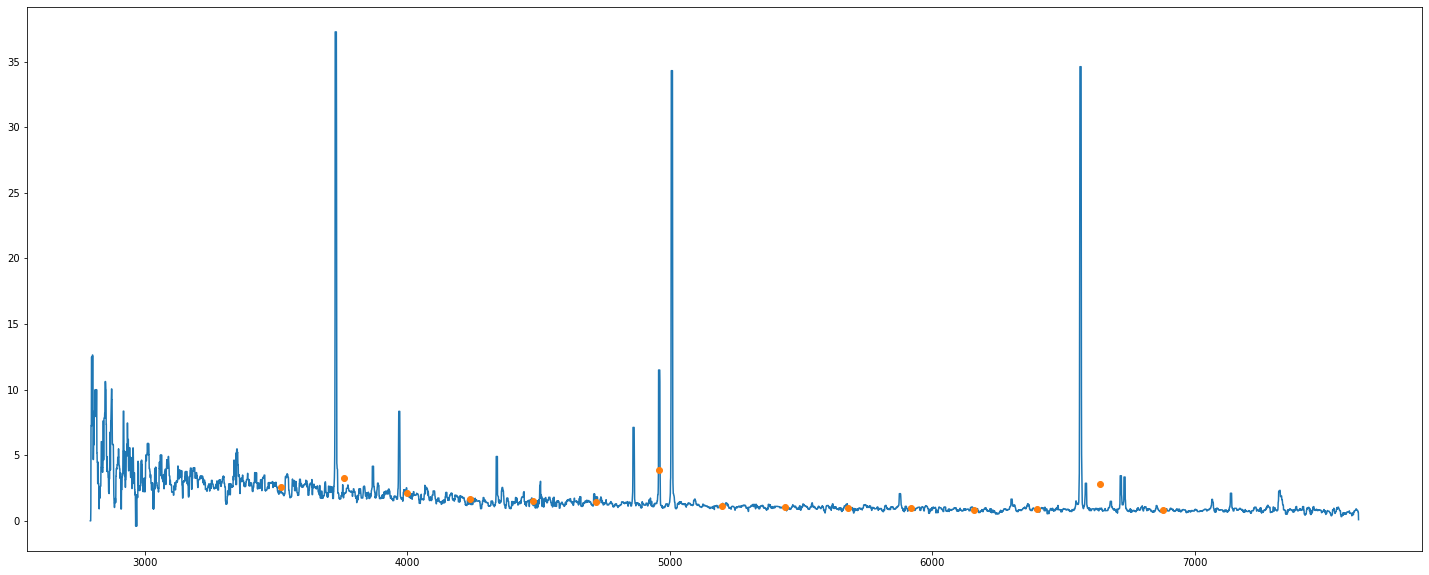

In [41]:
w1, w2 = 3400, 7000
d = np.average(.8/(1+zs))
Ns = [16]
pivot = []
effective_waves = []
wavelength = np.arange(3600, 9824+.8, .8)
c=3*10**18
for N in Ns:
    print(N)
    bin_ws = np.linspace(w1,w2,N)
    small_bins = []
    pivot_bins = []
    effective_waves_bins = []
    for i in range(N-1):
        small_bins.append(np.arange(bin_ws[i],bin_ws[i+1],d))
        pivot_bins.append(np.sqrt(np.average(small_bins[i])/np.average(1/small_bins[i])))
        effective_waves_bins.append(np.average(small_bins[i]))

    pivot.append(pivot_bins)
    effective_waves.append(effective_waves_bins)

i = 4305

plt.figure(1)
#plt.plot(wavelength/(1+zs[select_fluxes][i]), signal.medfilt(spectra[i-len(np.where(select_fluxes[:10*10**3])[0]),:], kernel_size=15)*(1+zs[select_fluxes][i]))
plt.plot(wavelength/(1+zs[select_fluxes][i]), signal.medfilt(spectra[i,:], kernel_size=15)*(1+zs[select_fluxes][i]))
plt.plot(effective_waves[0], fluxes_bin[i,:]*c/np.array(pivot[0])[:]**2, 'o')

16


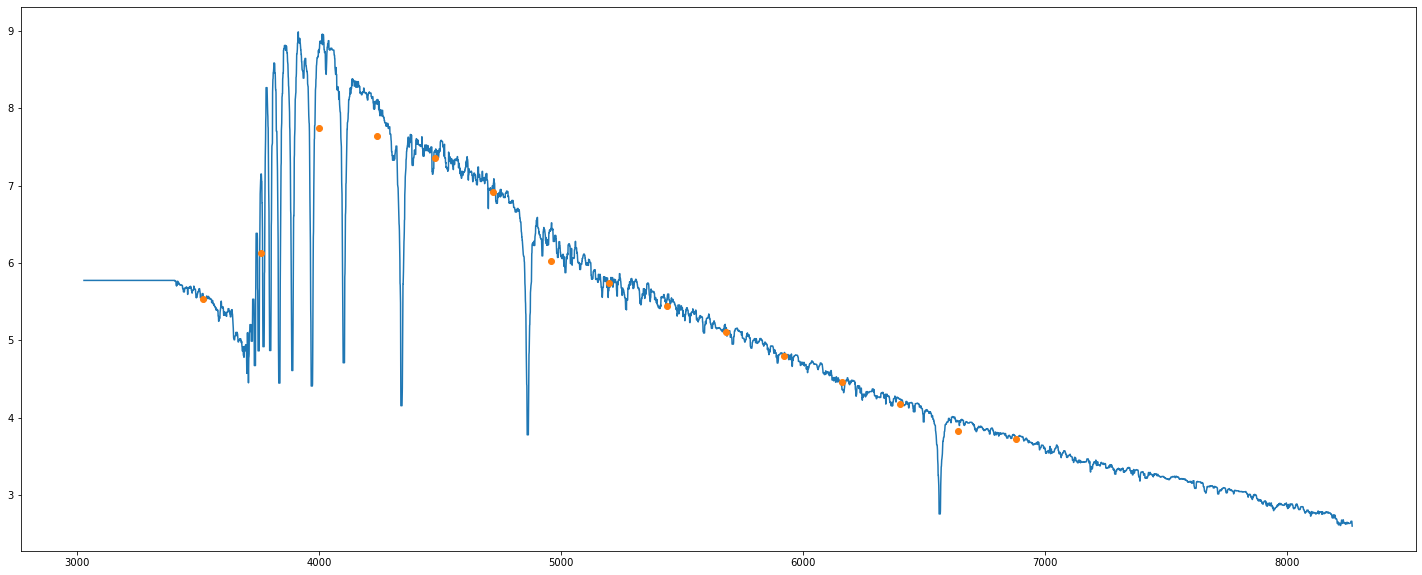

In [18]:
w1, w2 = 3400, 7000
d = np.average(.8/(1+zs))
Ns = [16]
pivot = []
effective_waves = []
wavelength = np.arange(3600, 9824+.8, .8)
c=3*10**18
for N in Ns:
    print(N)
    bin_ws = np.linspace(w1,w2,N)
    small_bins = []
    pivot_bins = []
    effective_waves_bins = []
    for i in range(N-1):
        small_bins.append(np.arange(bin_ws[i],bin_ws[i+1],d))
        pivot_bins.append(np.sqrt(np.average(small_bins[i])/np.average(1/small_bins[i])))
        effective_waves_bins.append(np.average(small_bins[i]))

    pivot.append(pivot_bins)
    effective_waves.append(effective_waves_bins)

i = 4999

plt.figure(1)
#plt.plot(wavelength/(1+zs[select_fluxes][i]), signal.medfilt(spectra[i-len(np.where(select_fluxes[:10*10**3])[0]),:], kernel_size=15)*(1+zs[select_fluxes][i]))
plt.plot(wavelength/(1+zs[select_fluxes][i]), signal.medfilt(spectra[i,:], kernel_size=15)*(1+zs[select_fluxes][i]))
plt.plot(effective_waves[0], fluxes_bin[i,:]*c/np.array(pivot[0])[:]**2, 'o')